# Trigger Revision for 2025/2026 Cyclone Season

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [49]:
from pathlib import Path
import pandas as pd
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.stats import zscore
import math
from datetime import datetime, timedelta
from src.datasources import codab, rsmc, imerg, helpers
from src import db_utils
from src.constants import *
from src.utils import *

In [3]:
adm1 = stratus.codab.load_codab_from_fieldmaps(iso3, admin_level=1)

In [4]:
landfall_df = stratus.load_csv_from_blob(
    "ds-aa-moz-cyclones/processed/landfall_time_location_fixed_adm1_v7_updated.csv",
    stage="dev",
    container_name="projects",
)
date_cols = ["year", "month", "day"]
landfall_df[date_cols] = landfall_df[date_cols].astype(int)
landfall_df["landfall_date"] = pd.to_datetime(
    landfall_df[["year", "month", "day"]]
)
landfall_df.tail()

,ISO_TIME,SID,SEASON,NUMBER,BASIN,NAME,LAT,LON,WMO_WIND,DIST2LAND,REU_LAT,REU_LON,REU_WIND,year,month,day,date,actual_within_land,point_location,landfall_date
25,11/03/2023 17:30,2023061S22036,2023,15.0,SI,FREDDY,-17.816667,37.116667,1094.166667,2.500000,NaN,NaN,NaN,2023,3,11,11/03/2023,True,Landfall,2023-03-11
26,12/03/2024 05:00,2024071S20039,2024,15.0,SI,FILIPO,-21.333333,35.033333,NaN,7.666667,NaN,NaN,NaN,2024,3,12,12/03/2024,True,Landfall,2024-03-12
27,NaN,2024345S11062,2025,NaN,SI,CHIDO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,12,15,NaN,NaN,NaN,2024-12-15
28,NaN,2025010S14060,2025,NaN,SI,DIKELEDI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,1,13,NaN,NaN,NaN,2025-01-13
29,NaN,2025068S15046,2025,NaN,SI,JUDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,3,10,NaN,NaN,NaN,2025-03-10


In [5]:
landfall_df

,ISO_TIME,SID,SEASON,NUMBER,BASIN,NAME,LAT,LON,WMO_WIND,DIST2LAND,REU_LAT,REU_LON,REU_WIND,year,month,day,date,actual_within_land,point_location,landfall_date
0,03/01/2000 05:00,1999357S08076,2000,103.0,SI,ASTRIDE,-13.633333,40.466667,30.500000,8.000000,-13.633333,40.466667,30.666667,2000,1,3,03/01/2000,True,Landfall,2000-01-03
1,22/02/2000 07:30,2000032S11116,2000,9.0,SI,ELINE:LEONE,-20.550000,34.750000,93.750000,7.500000,-20.500000,34.500000,94.000000,2000,2,22,22/02/2000,True,Landfall,2000-02-22
2,09/03/2000 00:30,2000058S14063,2000,14.0,SI,GLORIA,-23.983333,35.433333,25.000000,0.000000,-23.983333,35.433333,25.000000,2000,3,9,09/03/2000,True,Landfall,2000-03-09
3,08/04/2000 06:00,2000083S17102,2000,20.0,SI,HUDAH,-17.200000,38.300000,65.000000,0.000000,-17.200000,38.300000,65.000000,2000,4,8,08/04/2000,True,Landfall,2000-04-08
4,31/12/2002 21:30,2002364S16045,2003,99.0,SI,DELFINA,-15.983333,40.066667,47.083333,0.000000,-16.083333,40.050000,47.500000,2002,10,26,31/12/2002,True,Landfall,2002-10-26
5,02/03/2003 16:30,2003056S21042,2003,15.0,SI,JAPHET,-21.800000,35.250000,71.250000,5.000000,-21.700000,35.300000,71.500000,2003,3,2,02/03/2003,True,Landfall,2003-03-02
6,22/02/2007 10:00,2007043S11071,2007,7.0,SI,FAVIO,-21.900000,35.300000,91.666667,6.666667,-21.800000,35.300000,92.000000,2007,2,22,22/02/2007,True,Landfall,2007-02-22
7,08/03/2008 14:30,2008062S10064,2008,13.0,SI,JOKWE,-15.983333,40.133333,80.833333,1.666667,-15.983333,40.116667,80.833333,2008,3,8,08/03/2008,True,Landfall,2008-03-08
8,29/03/2009 13:30,2009082S16039,2009,19.0,SI,IZILDA,-20.200000,34.700000,20.000000,11.500000,-20.100000,34.550000,20.000000,2009,3,29,29/03/2009,True,Landfall,2009-03-29
9,16/01/2012 09:00,2012010S24049,2012,3.0,SI,DANDO,-24.800000,34.500000,42.500000,0.000000,-24.800000,34.500000,43.000000,2012,1,16,16/01/2012,True,Landfall,2012-01-16


In [6]:
query = """
SELECT * 
FROM storms.ibtracs_tracks_geo
WHERE basin = 'SI'
"""
with stratus.get_engine(stage="prod").connect() as con:
    gdf_tracks = gpd.read_postgis(query, con, geom_col="geometry")

In [7]:
query = """
SELECT *
FROM storms.ibtracs_storms
"""
with stratus.get_engine(stage="prod").connect() as con:
    df_storms = pd.read_sql(query, con)

In [8]:
df_storms[df_storms["name"] == "FREDDY"]

,sid,atcf_id,number,season,name,genesis_basin,provisional,storm_id
297,2023036S12117,SH112023,8,2023,FREDDY,SI,False,freddy_si_2023
12203,2009034S16126,SH142009,9,2009,FREDDY,SI,False,freddy_si_2009


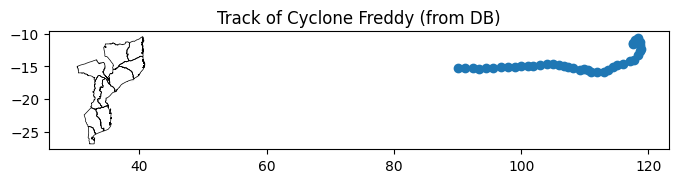

In [9]:
storm = gdf_tracks[gdf_tracks["sid"] == "2023036S12117"]

fig, ax = plt.subplots(figsize=(8, 6))
adm1.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.5)
storm.plot(ax=ax)

ax.set_title("Track of Cyclone Freddy (from DB)")
plt.show()

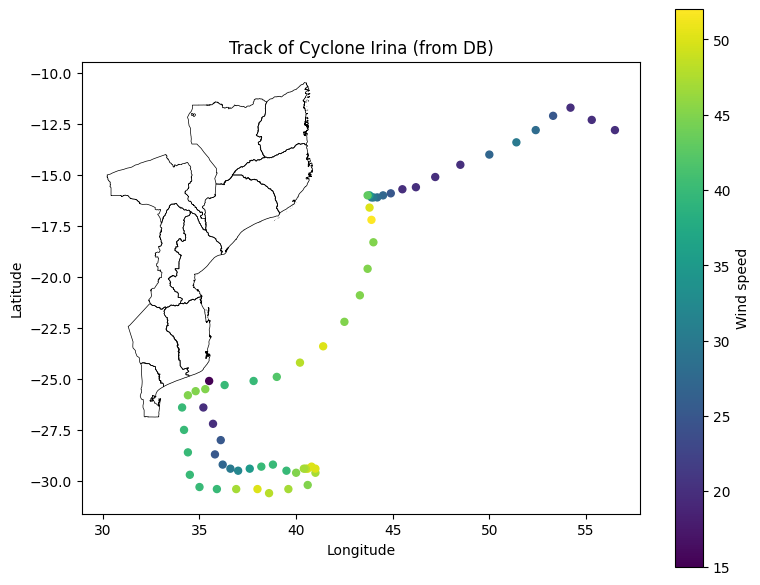

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

adm1.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.5)

storm = gdf_tracks[gdf_tracks["sid"] == "2012056S13057"].copy()
storm["wind_speed"] = pd.to_numeric(storm["wind_speed"], errors="coerce")

sc = ax.scatter(
    storm.geometry.x,
    storm.geometry.y,
    c=storm["wind_speed"],
    s=25,
)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Wind speed")

ax.set_title("Track of Cyclone Irina (from DB)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

In [11]:
gdf_tracks = gdf_tracks.merge(df_storms)

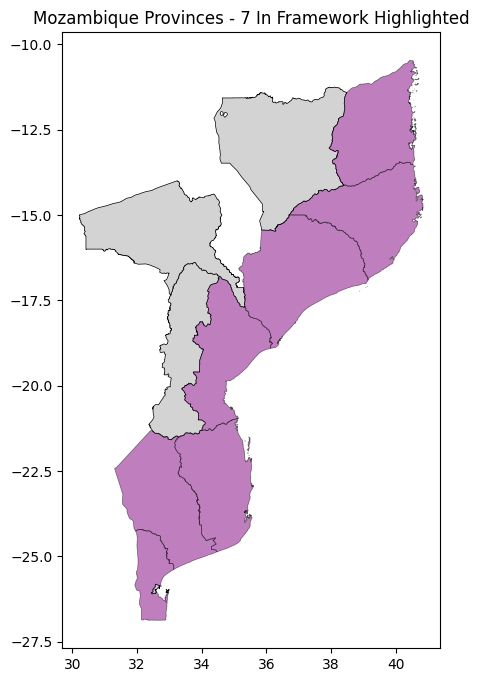

In [12]:
adm1["in_framework"] = adm1["adm1_name"].isin(ADMS)
fig, ax = plt.subplots(figsize=(10, 8))
adm1[adm1["in_framework"] == False].plot(
    ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5
)
adm1[adm1["in_framework"] == True].plot(
    ax=ax, color="purple", edgecolor="black", linewidth=0.5, alpha=0.5
)
ax.set_title("Mozambique Provinces - 7 In Framework Highlighted")
plt.show()

In [13]:
# to add the return period based on the revisions
# 7 provinces in the framework
# threshold of 118km/h (64 knots) for wind speed
# threshold of 120mm for rainfall over 3 days

# df_rsmc = rsmc.load_historical_forecast_distances()
# distance_cols = [x for x in df_rsmc.columns if "_distance_km" in x]
# df_rsmc["any_distance_km"] = df_rsmc[distance_cols].min(axis=1)

In [14]:
# intersecting df_rsmc with adm1 to get only the relevant provinces
df_rsmc = rsmc.load_processed_historical_forecasts()
# turn latitude and longitude into a geodataframe
df_rsmc = gpd.GeoDataFrame(
    df_rsmc,
    geometry=gpd.points_from_xy(df_rsmc["longitude"], df_rsmc["latitude"]),
    crs="OGC:CRS84",
)
df_rsmc_adm1 = gpd.sjoin(
    df_rsmc,
    adm1[adm1["in_framework"] == True],
    how="inner",
    predicate="within",
)
df_rsmc_adm1.head(5)

,cyclone_name,cyclone_number,basin,lt_hour,valid_time,latitude,longitude,min_presssure_hpa,last_isobar_pres_hpa,last_isobar_rad_nm,...,region2_nm,region1_cd,region1_nm,status_cd,status_nm,wld_date,wld_update,wld_view,wld_notes,in_framework
70,FREDDY,7,SWI,36,2023-03-11 18:00:00+00:00,-17.52,37.02,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True
71,FREDDY,7,SWI,48,2023-03-12 06:00:00+00:00,-17.34,36.58,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True
72,FREDDY,7,SWI,60,2023-03-12 18:00:00+00:00,-17.07,36.13,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True
73,FREDDY,7,SWI,72,2023-03-13 06:00:00+00:00,-16.80,35.48,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True
129,0620182019,6,SWI,84,2019-01-22 18:00:00+00:00,-18.56,35.08,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True


In [15]:
df_rsmc_adm1.columns

Index(['cyclone_name', 'cyclone_number', 'basin', 'lt_hour', 'valid_time',
       'latitude', 'longitude', 'min_presssure_hpa', 'last_isobar_pres_hpa',
       'last_isobar_rad_nm', 'max_wind_kt', 'max_wind_gusts_kt',
       'max_wind_radius_nm', 'nwq_27kt_nm', 'neq_27kt_nm', 'seq_27kt_nm',
       'swq_27kt_nm', 'nwq_34kt_nm', 'neq_34kt_nm', 'seq_34kt_nm',
       'swq_34kt_nm', 'nwq_50kt_nm', 'neq_50kt_nm', 'seq_50kt_nm',
       'swq_50kt_nm', 'issue_time', 'season', 'nwq_64kt_nm', 'neq_64kt_nm',
       'seq_64kt_nm', 'swq_64kt_nm', 'numberseason', 'geometry', 'index_right',
       'fid', 'adm1_id', 'adm1_src', 'adm1_name', 'adm1_name1', 'adm1_name2',
       'adm0_id', 'adm0_src', 'adm0_name', 'adm0_name1', 'adm0_name2',
       'src_lvl', 'src_lang', 'src_lang1', 'src_lang2', 'src_date',
       'src_update', 'src_name', 'src_name1', 'src_lic', 'src_url', 'src_grp',
       'iso_cd', 'iso_2', 'iso_3', 'iso_3_grp', 'region3_cd', 'region3_nm',
       'region2_cd', 'region2_nm', 'region1_cd'

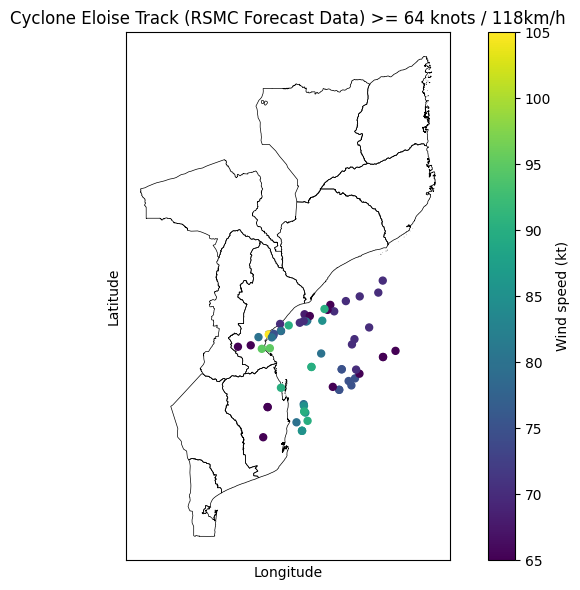

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

adm1.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.5)

irina = df_rsmc[df_rsmc["cyclone_name"].str.upper() == "ELOISE"].copy()

irina["max_wind_kt"] = pd.to_numeric(irina["max_wind_kt"], errors="coerce")
irina64 = irina[irina["max_wind_kt"] >= 64]

sc = ax.scatter(
    irina64.geometry.x,
    irina64.geometry.y,
    c=irina64["max_wind_kt"],
    s=25,
)
# plot actual irina track from gdf_tracks
irina_track = gdf_tracks[gdf_tracks["name"].str.upper() == "IRINA"].copy()
# irina_track.plot(ax=ax, color="red", markersize=5, label="Irina Actual Track")

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Wind speed (kt)")

ax.set_title("Cyclone Eloise Track (RSMC Forecast Data) >= 64 knots / 118km/h")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# remove x and y axes
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [17]:
IMERG_START_DATE = pd.to_datetime("2000-06-01")
extra_days = 1
aoi_adm1_pcodes = adm1[adm1["in_framework"]]["adm1_src"].unique()
dfs = []
for sid, row in landfall_df.set_index("SID").iterrows():
    landfall_date = row["landfall_date"]
    start_date = landfall_date - pd.Timedelta(days=extra_days)
    end_date = landfall_date + pd.Timedelta(days=extra_days)
    if end_date < IMERG_START_DATE:
        print(f"{row['NAME']} too early")
        continue
    df_in = imerg.fetch_imerg_data(aoi_adm1_pcodes, start_date, end_date)
    df_in["SID"] = sid
    df_in["NAME"] = row["NAME"]
    df_in["SEASON"] = row["SEASON"]
    dfs.append(df_in)
imerg_df = pd.concat(dfs, ignore_index=True)
imerg_sum_df = (
    imerg_df.groupby(["pcode", "SID", "NAME", "SEASON"])["mean"]
    .sum()
    .reset_index()
)
imerg_sum_df = imerg_sum_df.rename(columns={"mean": "sum_mean_rain"})
imerg_sum_df.head()

ASTRIDE too early
ELINE:LEONE too early
GLORIA too early
HUDAH too early


,pcode,SID,NAME,SEASON,sum_mean_rain
0,MZ01,2002364S16045,DELFINA,2003,0.016015
1,MZ01,2003056S21042,JAPHET,2003,0.171965
2,MZ01,2007043S11071,FAVIO,2007,12.483385
3,MZ01,2008062S10064,JOKWE,2008,47.419393
4,MZ01,2009082S16039,IZILDA,2009,16.721129


### Return Period

In [18]:
ibtracs_path = adm1_path = (
    Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
)
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_ibtracs = gpd.read_file(points_path)
# shifting to using the stratus loader

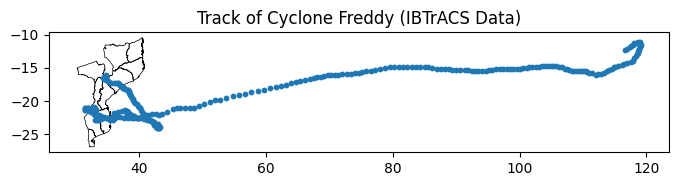

In [19]:
storm = gdf_ibtracs[
    (gdf_ibtracs["NAME"] == "FREDDY") & (gdf_ibtracs["year"] == 2023)
]

fig, ax = plt.subplots(figsize=(8, 6))
adm1.to_crs(gdf_ibtracs.crs).plot(
    ax=ax, edgecolor="black", facecolor="none", linewidth=0.5
)
storm.plot(ax=ax, markersize=10)

ax.set_title("Track of Cyclone Freddy (IBTrACS Data)")
plt.show()

In [20]:
def calculate_storm_return_period(
    df, wind_speed_kmh, start_year, num_storms_year
):
    """
    Calculates the return period for cyclones based on wind speed threshold.

    Args:
    df: DataFrame containing the cyclone data.
    wind_speed_kmh: Wind speed threshold in km/h.
    start_year: The year to start the calculation from.
    num_storms_year: Number of storms to predict per year.

    Returns:
    None (Prints the return period and probability).
    """
    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / KPH2KNOTS

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    df["year"] = (
        df["valid_time"]
        .astype(str)
        .apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year)
    )

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[
        (df["year"] >= start_year) & (df["wind_speed"] >= speed_knots)
    ]

    # Count unique storms
    unique_storms = df_filtered["name"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2025 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh}km/h is 1-in-{round(combined_return_period, 1)} years."
    )

    # http://hurricanepredictor.com/Methodology/USmethodology.pdf
    # Trying out the methodology above
    # using Poisson distribution
    ave_num = unique_storms / yr_len
    expected_probability = (
        math.exp(-ave_num)
        * (ave_num**num_storms_year)
        / math.factorial(num_storms_year)
    )
    print(
        f"Probability of {num_storms_year} or more storms occurring in any given year is {expected_probability:.4f}."
    )

In [21]:
adm1.to_crs(gdf_tracks.crs, inplace=True)
gdf_points_adm1 = gpd.sjoin(
    gdf_tracks, adm1, how="inner", predicate="intersects"
)
calculate_storm_return_period(gdf_points_adm1, THRESHOLD_SPEED_OPT2, 1980, 1)

The combined return period of storms over 118km/h is 1-in-3.3 years.
Probability of 1 or more storms occurring in any given year is 0.2245.


In [22]:
gdf_points_adm1[
    gdf_points_adm1["wind_speed"] >= (THRESHOLD_SPEED_OPT2 / KPH2KNOTS)
]["name"].unique()

array(['DIKELEDI', 'ANGELE', 'FILAO', 'ELINE:LEONE', 'HUDAH', 'JAPHET',
       'FAVIO', 'JOKWE', 'DINEO', 'IDAI', 'KENNETH', 'ELOISE', 'CHIDO',
       'JUDE', 'GOMBE'], dtype=object)

In [23]:
# why is Freddy not in this list?
# because the data in the DB is incomplete for Freddy
gdf_points_adm1[gdf_points_adm1["name"] == "FREDDY"]

,wind_speed,pressure,max_wind_radius,last_closed_isobar_radius,last_closed_isobar_pressure,gust_speed,sid,provider,basin,nature,...,region1_cd,region1_nm,status_cd,status_nm,wld_date,wld_update,wld_view,wld_notes,in_framework,year


### Historical Validation

#### Validation of Rainfall Impact (Cyclone-Induced Flooding)

In [54]:
floodscan_df_all = stratus.load_csv_from_blob(
    "ds-aa-moz-cyclones/processed/floodscan/floodscan_exposure_data_all.csv",
    stage="dev",
    container_name="projects",
)

In [73]:
baseline = (
    floodscan_df_all.groupby("pcode")["sum"]
    .agg(mean="mean", std="std", median="median")
    .reset_index()
)
baseline.head()

,pcode,mean,std,median
0,MZ01,590.437138,2290.900237,0.0
1,MZ02,4917.318195,24518.794014,96.0
2,MZ03,136.107245,715.613899,0.0
3,MZ04,283.692421,1186.416190,0.0
4,MZ05,2012.993807,8086.790490,0.0


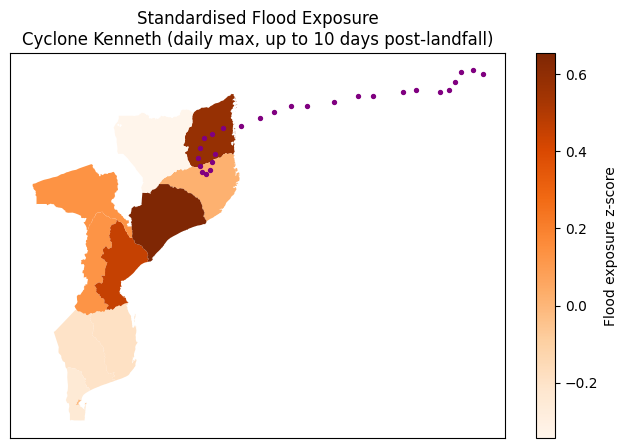

In [79]:
# plot the max flood exposure for Dando and Haruna using adm1
cyclone = "KENNETH"
start_date = landfall_df.loc[
    landfall_df["NAME"] == cyclone, "landfall_date"
].iloc[0] - pd.Timedelta(days=1)
end_date = start_date + pd.Timedelta(days=10)
floodscan_plot = (
    floodscan_df_all[
        pd.to_datetime(floodscan_df_all["valid_date"]).dt.date.between(
            start_date.date(), end_date.date()
        )
    ]
    .groupby("pcode")["sum"]
    .max()
    .reset_index()
)
floodscan_plot = floodscan_plot.merge(baseline, on="pcode", how="left")
floodscan_plot["zscore"] = (
    floodscan_plot["sum"] - floodscan_plot["mean"]
) / floodscan_plot["std"]
# join with adm1 to plot
floodscan_plot = adm1.merge(
    floodscan_plot, left_on="adm1_src", right_on="pcode"
)
fig, ax = plt.subplots(figsize=(8, 5))
# floodscan_plot.plot(ax=ax, column="sum", cmap="Oranges", legend=True)
floodscan_plot.plot(
    ax=ax,
    column="zscore",
    cmap="Oranges",
    legend=True,
    legend_kwds={"label": "Flood exposure z-score"},
)

# add cyclone dando track from gdf_tracks
dando = gdf_tracks[gdf_tracks["name"] == cyclone]
dando.plot(ax=ax, color="purple", markersize=8)
ax.set_title(
    f"Standardised Flood Exposure\n"
    f"Cyclone {cyclone.title()} (daily max, up to 10 days post-landfall)"
)
# remove longitude and latitude axis
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [26]:
floodscan_df_in = stratus.load_csv_from_blob(
    "ds-aa-moz-cyclones/processed/floodscan/floodscan_exposure_data.csv",
    stage="dev",
    container_name="projects",
)

In [27]:
FLOODSCAN_START_DATE = pd.to_datetime("2000-01-01")
extra_days = 10

moz_pcodes = ["MZ"]

dfs_fs = []

for sid, row in landfall_df.set_index("SID").iterrows():
    landfall_date = row["landfall_date"]
    start_date = landfall_date - pd.Timedelta(days=1)
    end_date = landfall_date + pd.Timedelta(days=extra_days)

    if end_date < FLOODSCAN_START_DATE:
        print(f"{row['NAME']} too early for FloodScan")
        continue

    df_fs = floodscan_df_in[
        pd.to_datetime(floodscan_df_in["valid_date"]).dt.date.between(
            start_date.date(), end_date.date()
        )
    ]
    df_out = df_fs.groupby(["pcode"])["sum"].max().reset_index()
    # print(f"Processing {row['NAME']} with {len(df_out)} records")
    df_out["SID"] = sid
    df_out["NAME"] = row["NAME"]
    df_out["SEASON"] = row["SEASON"]

    dfs_fs.append(df_out)

floodscan_df = pd.concat(dfs_fs, ignore_index=True)
floodscan_df = floodscan_df.rename(columns={"sum": "Max Flood Exposure"})

In [28]:
readiness_max_lt = 120
readiness_min_lt = 72
action_max_lt = 72
action_min_lt = 6
wind_speed_trigger_kmh = 118  # km/h
rainfall_trigger_mm = 120  # mm over 3 days, testing with 175mm
wind_speed_trigger_kts = 64  # knots

In [29]:
# getting last 8 digits to get seasons from column "numberseason"

num_seasons = (df_rsmc["numberseason"].astype(str).str[-8:]).nunique()
num_seasons

14

In [30]:
# checking the number of storms that would have triggered readiness
readiness_storms = df_rsmc_adm1[
    df_rsmc_adm1["lt_hour"].between(
        readiness_min_lt, readiness_max_lt, inclusive="both"
    )
    & (df_rsmc_adm1["max_wind_kt"] >= wind_speed_trigger_kts)
]["cyclone_name"].unique()
# adding recent storms
readiness_storms = list(readiness_storms) + ["CHIDO", "JUDE"]
readiness_storms

['IDAI',
 'IRINA',
 'GOMBE',
 '1420182019',
 'ELOISE',
 'FREDDY',
 'KENNETH',
 'CHIDO',
 'JUDE']

In [31]:
# readiness return period
num_seasons / len(readiness_storms)

1.5555555555555556

In [32]:
# checking the number of storms that would have triggered action
action_storms = df_rsmc_adm1[
    df_rsmc_adm1["lt_hour"].between(
        action_min_lt, action_max_lt, inclusive="both"
    )
    & (df_rsmc_adm1["max_wind_kt"] >= wind_speed_trigger_kts)
]["cyclone_name"].unique()
# adding chido, dikeledi and jude
action_storms = list(action_storms) + ["CHIDO", "DIKELEDI", "JUDE"]
action_storms

['IDAI',
 'GOMBE',
 'KENNETH',
 'ELOISE',
 'FREDDY',
 '1420182019',
 'IRINA',
 'DINEO',
 'CHIDO',
 'DIKELEDI',
 'JUDE']

In [33]:
# readiness return period
num_seasons / len(action_storms)

1.2727272727272727

In [34]:
obs_ws_storms = df_rsmc_adm1[
    df_rsmc_adm1["lt_hour"].between(0, action_min_lt, inclusive="both")
    & (df_rsmc_adm1["max_wind_kt"] >= wind_speed_trigger_kts)
]["cyclone_name"].unique()
obs_ws_storms = list(obs_ws_storms) + ["CHIDO", "DIKELEDI", "JUDE"]
obs_ws_storms

['IDAI', 'DINEO', 'GOMBE', 'KENNETH', 'FREDDY', 'CHIDO', 'DIKELEDI', 'JUDE']

In [35]:
# readiness return period
num_seasons / len(obs_ws_storms)

1.75

In [36]:
imerg_sum_df[imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm]

,pcode,SID,NAME,SEASON,sum_mean_rain
13,MZ01,2019112S10053,KENNETH,2019,154.855522
24,MZ01,2025068S15046,JUDE,2025,126.229170
51,MZ03,2003056S21042,JAPHET,2003,120.842538
118,MZ07,2022065S16055,GOMBE,2022,160.615137
123,MZ07,2025010S14060,DIKELEDI,2025,177.233882
124,MZ07,2025068S15046,JUDE,2025,215.957052
136,MZ09,2019018S24033,DESMOND,2019,142.983775
137,MZ09,2019063S18038,IDAI,2019,233.761901
162,MZ11,2019063S18038,IDAI,2019,155.127643
167,MZ11,2022020S13059,ANA,2022,172.006284


In [37]:
imerg_sum_df[imerg_sum_df["NAME"] == "DANDO"]

,pcode,SID,NAME,SEASON,sum_mean_rain
5,MZ01,2012010S24049,DANDO,2012,85.482360
30,MZ02,2012010S24049,DANDO,2012,50.632482
55,MZ03,2012010S24049,DANDO,2012,31.567817
80,MZ05,2012010S24049,DANDO,2012,90.553978
105,MZ07,2012010S24049,DANDO,2012,57.134268
130,MZ09,2012010S24049,DANDO,2012,7.982671
155,MZ11,2012010S24049,DANDO,2012,13.196729


In [38]:
# return period of rainfall storms
((2025 - IMERG_START_DATE.year) + 1) / (
    imerg_sum_df[imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm][
        "NAME"
    ].nunique()
)

2.888888888888889

In [39]:
# return period of rainfall storms
((2025 - IMERG_START_DATE.year) + 1) / (
    imerg_sum_df[imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm][
        "SEASON"
    ].nunique()
)

5.2

In [40]:
gdf_points_adm1 = gdf_points_adm1[gdf_points_adm1["year"] >= 1980]

In [41]:
# wind speed return period
round(
    (2025 - 1980 + 1)
    / (
        gdf_points_adm1[
            (
                gdf_points_adm1["wind_speed"]
                >= (THRESHOLD_SPEED_OPT2 / KPH2KNOTS)
            )
            & (gdf_points_adm1["year"] >= 1980)
        ]["name"].nunique()
        + 1
    ),
    1,
)

3.1

In [42]:
# wind speed return period
# by activation season
round(
    (2025 - 1980 + 1)
    / (
        gdf_points_adm1[
            (
                gdf_points_adm1["wind_speed"]
                >= (THRESHOLD_SPEED_OPT2 / KPH2KNOTS)
            )
            & (gdf_points_adm1["year"] >= 1980)
        ]["season"].nunique()
        + 1
    ),
    1,
)

4.2

In [43]:
pd.concat(
    [
        gdf_points_adm1.loc[
            (
                gdf_points_adm1["wind_speed"]
                >= (THRESHOLD_SPEED_OPT2 / KPH2KNOTS)
            ),
            "name",
        ],
        imerg_sum_df.loc[
            imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm, "NAME"
        ],
    ],
    ignore_index=True,
)

0        DIKELEDI
1        DIKELEDI
2           FILAO
3     ELINE:LEONE
4     ELINE:LEONE
5           HUDAH
6          JAPHET
7           FAVIO
8           FAVIO
9           JOKWE
10          DINEO
11           IDAI
12        KENNETH
13         ELOISE
14          CHIDO
15           JUDE
16          GOMBE
17        KENNETH
18           JUDE
19         JAPHET
20          GOMBE
21       DIKELEDI
22           JUDE
23        DESMOND
24           IDAI
25           IDAI
26            ANA
27         FREDDY
dtype: object

In [44]:
# combined return period
round(
    (2025 - 1980 + 1)
    / pd.concat(
        [
            gdf_points_adm1.loc[
                gdf_points_adm1["wind_speed"]
                >= (THRESHOLD_SPEED_OPT2 / KPH2KNOTS),
                "name",
            ],
            imerg_sum_df.loc[
                imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm, "NAME"
            ],
        ],
        ignore_index=True,
    ).nunique(),
    1,
)

2.7

In [45]:
# combined return period
round(
    (2025 - 1980 + 1)
    / pd.concat(
        [
            gdf_points_adm1.loc[
                gdf_points_adm1["wind_speed"]
                >= (THRESHOLD_SPEED_OPT2 / KPH2KNOTS),
                "season",
            ],
            imerg_sum_df.loc[
                imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm, "SEASON"
            ],
        ],
        ignore_index=True,
    ).nunique(),
    1,
)

4.2

In [46]:
# Complete list of storms
storm_cerf_file = pd.read_csv(
    rsmc.DATA_DIR / "public" / "raw" / "moz" / "storms_cerf_data.csv"
)

In [80]:
# Lists of storm events
df = storm_cerf_file.copy()
df["Readiness"] = df["storm"].isin(readiness_storms)
df["Action"] = df["storm"].isin(action_storms)
df["Observational Wind Speed"] = df["storm"].isin(obs_ws_storms)
df["Observational Rainfall"] = df["storm"].isin(
    imerg_sum_df[imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm]["NAME"]
)
df = df.merge(
    floodscan_df.drop_duplicates(subset=["NAME"])[
        ["NAME", "Max Flood Exposure"]
    ],
    left_on="storm",
    right_on="NAME",
    how="left",
)
df = df.merge(
    gdf_points_adm1.drop_duplicates(subset=["name", "season"])[
        ["name", "season"]
    ],
    left_on="storm",
    right_on="name",
    how="left",
)
# fill in Freddy's season
df.loc[df["storm"] == "FREDDY", "season"] = 2023
df = df[
    [
        "storm",
        "season",
        "Readiness",
        "Action",
        "Observational Wind Speed",
        "Observational Rainfall",
        "Total Affected",
        "CERF Allocations",
        "Max Flood Exposure",
    ]
]

# Sort the DataFrame by 'Total Affected' in descending order
# Round values in 'Total Affected' and 'CERF Allocations' columns
df_sorted = df.sort_values(by="Total Affected", ascending=False)

# Apply styling
styled_df = (
    df_sorted.style.map(
        highlight_true,
        subset=[
            "Readiness",
            "Action",
            "Observational Wind Speed",
            "Observational Rainfall",
        ],
    )
    .map(lambda v: color_bar_affected(df_sorted, v), subset=["Total Affected"])
    .map(lambda v: color_bar_cerf(df_sorted, v), subset=["CERF Allocations"])
    .map(
        lambda v: color_bar_affected(df_sorted, v),
        subset=["Max Flood Exposure"],
    )
    .format(
        {
            "Total Affected": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "CERF Allocations": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "Max Flood Exposure": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "season": "{:.0f}",
        }
    )
    .set_table_styles(
        {"": [{"selector": "table", "props": "background-color: white;"}]}
    )
)

styled_df

,storm,season,Readiness,Action,Observational Wind Speed,Observational Rainfall,Total Affected,CERF Allocations,Max Flood Exposure
12,IDAI,2019,True,True,True,True,"1,628,167","14,018,121","364,594"
20,FREDDY,2023,True,True,True,True,"1,230,691","9,995,213","723,677"
10,DINEO,2017,False,True,True,False,"750,102","2,000,095","104,921"
18,GOMBE,2022,True,True,True,True,"736,015","4,018,682","390,913"
15,ELOISE,2021,True,True,False,False,"481,901",,"209,013"
22,CHIDO,2025,True,True,True,False,"453,971","3,999,970","85,715"
13,KENNETH,2019,True,True,True,True,"400,094","9,964,907","99,798"
24,JUDE,2025,True,True,True,True,"385,000","6,053,738","369,965"
23,DIKELEDI,2025,False,True,True,True,"283,334",,"286,228"
1,JOKWE,2008,False,False,False,False,"220,013","548,913","131,490"
